## About Notebook

Implements two CNN models for the purpose of classifying images within the dataset:

- A minimal custom cnn architecture with the following minimum architecture: 
Input -> CV(relu) -> BN -> Pool -> CV(relu) -> BN -> Pool -> -> FC(relu) ->  FC(relu)  FC(relu)  -> FC(SoftMax)

- A fine-tuning of a 50-layer ResNet model with a final FC layer with softmax activation

## About DataSet

This dataset is the Potato Disease Detection Dataset uploaded to Kaggle [https://www.kaggle.com/datasets/mgmitesh/potato-disease-detection-dataset/data].

This dataset is curated for training and evaluating models to detect and classify potato leaf diseases using image-based deep learning techniques. It supports plant pathology research and agricultural automation.

The dataset contains three directories:

    Potato_Early_Blight/: Images of potato leaves affected by early blight, caused by the Alternaria fungus
    Potato_Late_Blight/: Images showing late blight, a serious disease caused by Phytophthora infestans.
    Potato_Healthy/: Images of healthy potato leaves with no visible disease symptoms.


## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import ResNet50V2

## Prepare/Read Dataset
The original dataset is a set of JPG images in three directories called,

- Potato__Early_blight
- Potato__healthy
- Potato__Late_blight

In [2]:
input_base_path = "working/input"
def dir_to_list(directory_name:'str'):
    files = os.listdir(os.path.join(input_base_path, str(directory_name)))
    return files
def health_list_function(potato_list:'list', condition:'str'): 
    return list(map(lambda x : condition, potato_list))
# notebook_path = os.listdir('input/Potato___Early_blight')
# print(notebook_path)

In [3]:
state_names = ["Potato___Early_blight", "Potato___healthy", "Potato___Late_blight"]
state_mapping = {"early_blight" : "Potato___Early_blight", "healthy" : "Potato___healthy", "late_blight" : "Potato___Late_blight"}
early_blight_filename_list = dir_to_list(state_mapping["early_blight"])
healthy_filename_list = dir_to_list(state_mapping["healthy"])
late_blight_filename_list = dir_to_list(state_mapping["late_blight"])
# healthy_df = pd.DataFrame(dir_to_list(Potato___healthy), healthy)
# late_blight_df = pd.DataFrame(dir_to_list(Potato___Late_blight), Potato___Late_blight)

In [4]:
early_blight_condition_list = health_list_function(early_blight_filename_list, state_mapping['early_blight'])
healthy_condition_list = health_list_function(healthy_filename_list, state_mapping['healthy'])
late_blight_condition_list = health_list_function(late_blight_filename_list, state_mapping['late_blight'])

In [5]:
early_blight_df = pd.DataFrame(data = {'Filename' : early_blight_filename_list, 'Health_Condition' : early_blight_condition_list})
healthy_df = pd.DataFrame(data = {'Filename' : healthy_filename_list, 'Health_Condition' : healthy_condition_list})
late_blight_df = pd.DataFrame(data = {'Filename' : late_blight_filename_list, 'Health_Condition' : late_blight_condition_list})

In [6]:
print(early_blight_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 15.8+ KB
None


In [7]:
print(healthy_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 2.5+ KB
None


In [8]:
print(late_blight_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 15.8+ KB
None


In [9]:
frames = [early_blight_df, healthy_df, late_blight_df]
potato_df = pd.concat(frames, ignore_index=True)

In [10]:
print(potato_df.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Filename          2152 non-null   object
 1   Health_Condition  2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB
None


## Properties of image files

### Check basic properties of first image file

In [11]:
image_filename = potato_df['Filename'][0]
image_condition = potato_df['Health_Condition'][0]
image_path = os.path.join(input_base_path, image_condition, image_filename)
print(image_path)
image = cv.imread(image_path)
height, width, channels = image.shape
print(f'height:{height} width:{width} channel:{channels}')

working/input\Potato___Early_blight\001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG
height:256 width:256 channel:3


### Check if any of the image files are sized differently from the first

In [12]:
for row in potato_df.itertuples():
    dims0 = (256, 256, 3)
    image_path = os.path.join(input_base_path, row.Health_Condition, row.Filename)
    image = cv.imread(image_path)
    dims = image.shape
    if dims == dims0:
        continue
    else:
        print(f'Warning: Dimension of following file does not match: {image_path}\n')
        continue

## Creating Test/Train Directories

Create Test/train directories for each class (state) as with the following structure for use by tf.keras.utils.image_dataset_from_directory():
- Potato__Early_blight
    - train
    - test
- Potato__healthy
    - train
    - test
- Potato__Late_blight
    - train
    - test

In [13]:
output_base_path = "working/model_data"
train_dir = os.path.join(output_base_path, "train")
test_dir = os.path.join(output_base_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# state_names = potato_df['Health_Condition'].unique()
# print(potato_df[potato_df['Health_Condition']==state_mappings['early_blight']]['Filename'])
# print(state_names[0])
# print(potato_df['Health_Condition'])
for state, value in state_mapping.items():
    os.makedirs(os.path.join(train_dir, value), exist_ok = True)
    os.makedirs(os.path.join(test_dir, value), exist_ok = True)

## Sorting Data into Test/Train Directories

In [14]:
def sort_and_copy_data(test_size = 0.2, random_state = 42):
    """
        Splits and copies images into training and testing directories
        Args:
            test_size: Proportion of images to allocate for testing the model (0.0 - 1.0)
            random_state: Seed value used to split images into training and test directories
    """
    #Tracks number of images for each state
    state_counts = {state: 0 for state in state_mapping.keys()}
    test_counts = {state: 0 for state in state_mapping.keys()}
    train_counts = {state: 0 for state in state_mapping.keys()}

    for state, value in state_mapping.items():
        files = potato_df[potato_df['Health_Condition']==value]['Filename']
        state_counts[state] += files.shape[0]
        
        #Splits the images into train and test directories
        train_files, test_files = train_test_split(files, test_size = test_size, random_state = random_state)
        for file in train_files:
            source_dir = os.path.join(input_base_path, value, file)
            destination_dir = os.path.join(train_dir, value, file)
            shutil.copy2(source_dir, destination_dir)
            train_counts[state] += 1
            
        for file in test_files:
            source_dir = os.path.join(input_base_path, value, file)
            destination_dir = os.path.join(test_dir, value, file)
            shutil.copy2(source_dir, destination_dir)
            test_counts[state] += 1

    return state_counts, train_counts, test_counts
            
    

In [15]:
state_counts, train_counts, test_counts = sort_and_copy_data()

## Visualize Test/Train Distribution 

In [16]:
print('Data Set Distribution:')
print('-'*50)
print(f'{'State':<15}{'Total':<10}{'Train':<10}{'Test'}')
print('-'*50)
for keys, values in state_mapping.items():
    print(f'{keys:<15}{state_counts[keys]:<10}{train_counts[keys]:<10}{test_counts[keys]}')
    
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total = total_train + total_test

print(f'{'Total':<15}{total:<10}{total_train:<10}{total_test}')


Data Set Distribution:
--------------------------------------------------
State          Total     Train     Test
--------------------------------------------------
early_blight   1000      800       200
healthy        152       121       31
late_blight    1000      800       200
Total          2152      1721      431


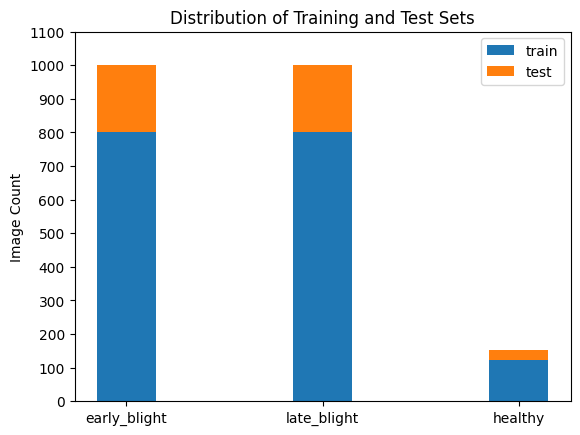

In [17]:
states = list(state_mapping.keys())
states = states[0:3:2] + [states[1]]
train_population = [train_counts[keys] for keys in states]
test_population = [test_counts[keys] for keys in states]
N = np.arange(len(states))
width = 0.3

fig = plt.subplots()
train_bar = plt.bar(N, train_population, width)
test_bar = plt.bar(N, test_population, width, bottom = train_population)

plt.ylabel("Image Count")
plt.xticks(N, states)
plt.yticks(np.arange(0, 1101, 100))
plt.legend((train_bar, test_bar),('train', 'test'))
plt.title('Distribution of Training and Test Sets')

plt.show()

Unfortunately the populations of potatoes are heavily unbalanced. So weights will need to be applied while training the model to emphasise data from the healthy potatoes.

## Load Train/Test data

In [18]:
print(train_dir)
print(test_dir)

working/model_data\train
working/model_data\test


In [19]:
height = 256
width = 256
batch_size = 32
class_names = list(state_mapping.values())
class_names = class_names[0:3:2] + [class_names[1]] #early_blight, late_blight, healthy

#keras function returns batch of images with a label corresponding to the state (class) of the images
#described in detail here: https://keras.io/api/data_loading/image/
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = class_names,
    batch_size = batch_size,
    image_size = (height, width),
    shuffle = True,
    interpolation = 'nearest',
    verbose = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = class_names,
    batch_size = batch_size,
    image_size = (height, width),
    shuffle = True,
    interpolation = 'nearest',
    verbose = False
)

## Image Normalization
I want to try several different models and so will normalize the data instead of explicitly doing so in each model (ie normalization layers).

In [20]:
def normalize_img(image, label):
    """
    normalizes pixel values from 0-255 to 0-1
    """
    image_norm = tf.cast(image, tf.float32) / (255.0)
    return image_norm, label
    
train_ds = train_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

## Optimize Runtime of Dataset 

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

#Caching
train_ds = train_ds.cache()
test_ds = test_ds.cache()

#Prefetching
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)


## Custom Model

Input -> CV(relu) -> BN -> Pool -> CV(relu) -> BN -> Pool -> -> FC(relu) ->  FC(relu)  FC(relu)  -> FC(SoftMax)


In [22]:
height = 256
width = 256
channels = 3
num_state = 3 #healthy, early_blight, late_blight

model1 = Sequential([
    Input(shape = (height, width, channels)),
    
    Conv2D(filters=6, kernel_size=(3,3), strides=1, padding='same', data_format='channels_last', activation='relu', use_bias = True),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True),
    MaxPooling2D(pool_size=(2,2), strides=None),
    
    Conv2D(filters=12, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True),
    MaxPooling2D(pool_size=(2,2)),
    
    # Conv2D(filters=24, kernel_size=(3,3), padding='same', strides=1, activation='relu'),
    # BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True),
    # MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(units=128, activation='relu', use_bias=True),
    # Dropout(0.5),
    
    Dense(units=64, activation='relu'),
    # Dropout(0.5),

    Dense(units=32, activation='relu'),
    # Dropout(0.5),
    
    Dense(units=num_state, activation='softmax')
])

model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 12)        │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 12)        │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,302,919 (24.04 MB)

 Trainable params: 6,302,883 (24.04 MB)

 Non-trainable params: 36 (144.00 B)

### Normalize the weights for each class

In [23]:
train_counts_early_blight = train_counts['early_blight']
train_counts_late_blight = train_counts['late_blight']
train_counts_healthy = train_counts['healthy']
total_train = sum(train_counts.values())
class_weight = {0 : (total_train / train_counts_early_blight) / 3.0, 
                1 : (total_train / train_counts_late_blight) / 3.0, 
                2 : (total_train / train_counts_healthy) / 3.0
               }
print(class_weight)

{0: 0.7170833333333334, 1: 0.7170833333333334, 2: 4.741046831955923}


### Fit the Custom Model

In [24]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
ReduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr = 0.0001)
history1 = model1.fit(
    train_ds,
    validation_data=test_ds,
    callbacks = [
        EarlyStopping,
        ReduceLROnPlateau
    ],
    class_weight = class_weight,
    epochs = 100,
    verbose = 1
)
results_model1 = pd.DataFrame(history1.history)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.7437 - loss: 2.3606 - val_accuracy: 0.8306 - val_loss: 0.6201 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9468 - loss: 0.3976 - val_accuracy: 0.4664 - val_loss: 8.1697 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9544 - loss: 0.4539 - val_accuracy: 0.4640 - val_loss: 29.3371 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9686 - loss: 0.1762 - val_accuracy: 0.4640 - val_loss: 22.2279 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9883 - loss: 0.0379 - val_accuracy: 0.4756 - val_loss: 16.1914 - learning_rate: 2.0000e-04
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.5684 - val_loss: 9.0562 - learning_rate: 2.0000e-04
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy:

## Setup a Resnet Model

In [25]:
height = 256
width = 256
channels = 3
num_state = 3 #healthy, early_blight, late_blight

base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(height, width, channels)
)

In [26]:
base_model.trainable = False

In [27]:
inputs = Input(shape=(height, width, channels))
# Preprocess data to have a range of [-1, 1] for use by resnet
inputs = keras.applications.resnet.preprocess_input(inputs)
# Inputs preprocessed data into resnet model
x = base_model(inputs)
# Applies an average pooling to model
x = GlobalAveragePooling2D()(x)
# outputs for a three class problem
outputs = Dense(3, activation='softmax')(x)

model_resnet = Model(inputs, outputs)

## Fine-tune Resnet Model

In [28]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
ReduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr = 0.0001)

model_resnet.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=test_ds,
    callbacks = [
        EarlyStopping,
        ReduceLROnPlateau
    ],
    class_weight = class_weight,
    epochs = 30,
    verbose = 1
)
results_resnet = pd.DataFrame(history_resnet.history)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 934ms/step - accuracy: 0.6286 - loss: 11.6694 - val_accuracy: 0.9304 - val_loss: 1.1275 - learning_rate: 0.1000
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 907ms/step - accuracy: 0.9345 - loss: 1.0347 - val_accuracy: 0.9466 - val_loss: 0.6285 - learning_rate: 0.1000
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 901ms/step - accuracy: 0.9732 - loss: 0.3427 - val_accuracy: 0.9629 - val_loss: 0.2373 - learning_rate: 0.1000
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 904ms/step - accuracy: 0.9577 - loss: 0.5679 - val_accuracy: 0.9072 - val_loss: 1.6174 - learning_rate: 0.1000
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 914ms/step - accuracy: 0.9480 - loss: 0.5959 - val_accuracy: 0.9629 - val_loss: 0.5070 - learning_rate: 0.1000
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 918ms/step - accuracy: 0.9813 - loss: 0.2759 - val_accuracy: 0.9513 - val_loss: 0.6715 - learning_rate: 0.0200
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 962ms/step - accuracy: 0.9890 - loss: 0

In [29]:
model1_accuracy = results_model1['accuracy'].values
model1_loss = results_model1['loss'].values
model1_val_accuracy = results_model1['val_accuracy'].values
model1_val_loss = results_model1['val_loss'].values
model1_epochs = range(len(model1_accuracy))

In [30]:
resnet_accuracy = results_resnet['accuracy'].values
resnet_loss = results_resnet['loss'].values
resnet_val_accuracy = results_resnet['val_accuracy'].values
resnet_val_loss = results_resnet['val_loss'].values
resnet_epochs = range(len(resnet_accuracy))

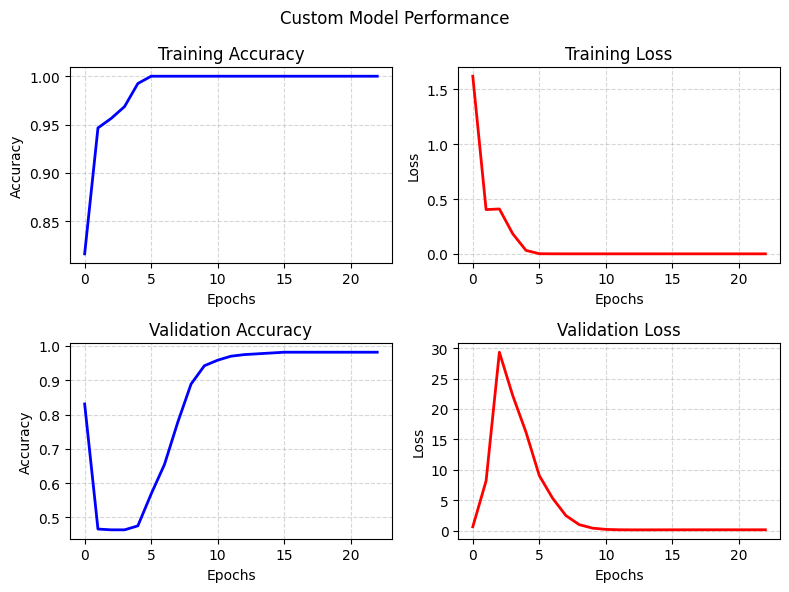

In [31]:
plt.figure(figsize = (8, 6))
plt.subplot(2,2,1)
plt.plot(model1_epochs, model1_accuracy, 'b-', linewidth=2,  label = 'model1')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,2)
plt.plot(model1_epochs, model1_loss, 'r-', linewidth=2,  label = 'model1')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,3)
plt.plot(model1_epochs, model1_val_accuracy, 'b-', linewidth=2,  label = 'model1')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,4)
plt.plot(model1_epochs, model1_val_loss, 'r-', linewidth=2, label = 'model1')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Custom Model Performance")
plt.tight_layout()
plt.show()

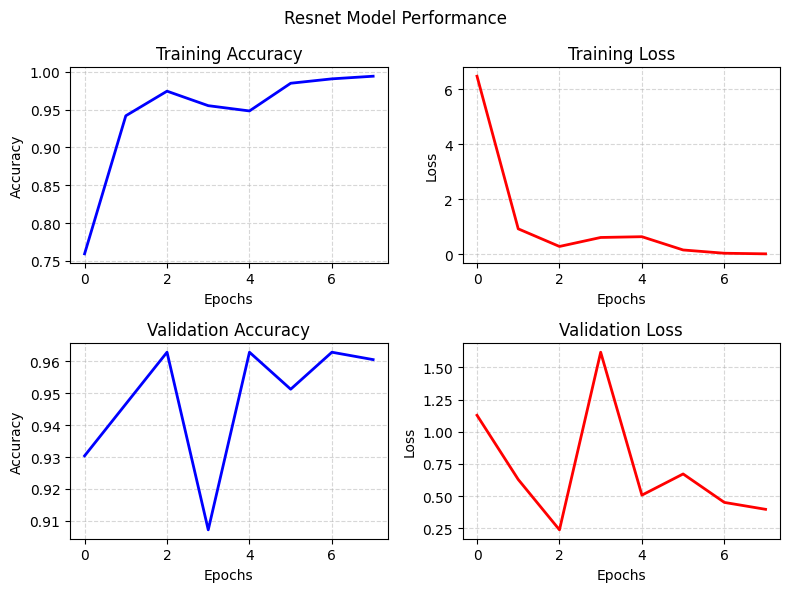

In [32]:
plt.figure(figsize = (8, 6))
plt.subplot(2,2,1)
plt.plot(resnet_epochs, resnet_accuracy, 'b-', linewidth=2,  label = 'resnet')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,2)
plt.plot(resnet_epochs, resnet_loss, 'r-', linewidth=2,  label = 'resnet')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,3)
plt.plot(resnet_epochs, resnet_val_accuracy, 'b-', linewidth=2,  label = 'resnet')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,4)
plt.plot(resnet_epochs, resnet_val_loss, 'r-', linewidth=2, label = 'resnet')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Resnet Model Performance")
plt.tight_layout()
plt.show()

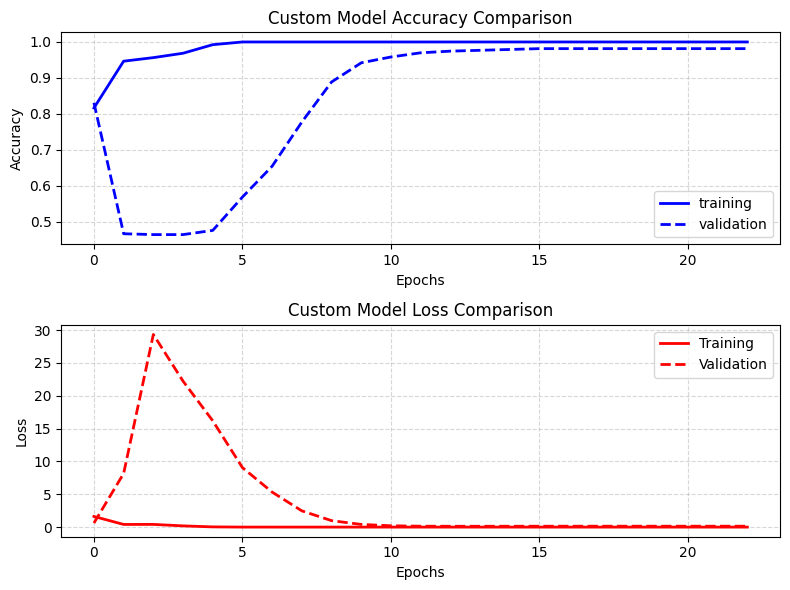

In [33]:
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
plt.plot(model1_epochs, model1_accuracy, 'b-', linewidth=2,  label = 'training')
plt.plot(model1_epochs, model1_val_accuracy, 'b--', linewidth=2,  label = 'validation')
plt.title("Custom Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(model1_epochs, model1_loss, 'r-', linewidth=2,  label = 'Training')
plt.plot(model1_epochs, model1_val_loss, 'r--', linewidth=2,  label = 'Validation')
plt.title("Custom Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

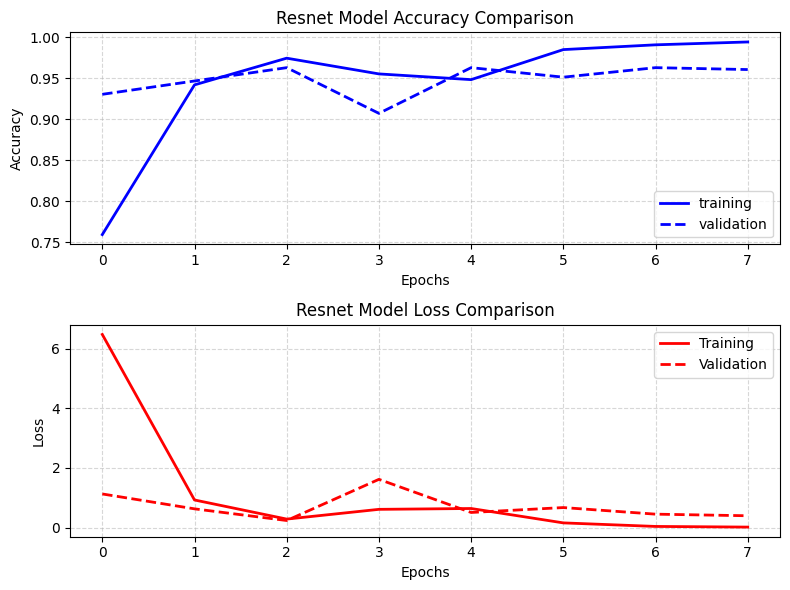

In [34]:
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
plt.plot(resnet_epochs, resnet_accuracy, 'b-', linewidth=2,  label = 'training')
plt.plot(resnet_epochs, resnet_val_accuracy, 'b--', linewidth=2,  label = 'validation')
plt.title("Resnet Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(resnet_epochs, resnet_loss, 'r-', linewidth=2,  label = 'Training')
plt.plot(resnet_epochs, resnet_val_loss, 'r--', linewidth=2,  label = 'Validation')
plt.title("Resnet Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

In [35]:
model1_Validation_test = model1.predict(test_ds)
model1_Validation_prediction = np.argmax(model1_Validation_test, axis = -1)
model1_Validation_reference=[]
for images, labels in test_ds.unbatch():
    model1_Validation_reference.append(int(np.argmax(labels.numpy()))) # or 
model1_Validation_reference = np.array(model1_Validation_reference)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [36]:
resnet_Validation_test = model_resnet.predict(test_ds)
resnet_Validation_prediction = np.argmax(resnet_Validation_test, axis = -1)
resnet_Validation_reference=[]
for images, labels in test_ds.unbatch():
    resnet_Validation_reference.append(int(np.argmax(labels.numpy()))) # or 
resnet_Validation_reference = np.array(resnet_Validation_reference)

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 743ms/step


In [37]:
model1_conf_matrix = confusion_matrix(model1_Validation_reference, model1_Validation_prediction)
model1_conf_matrix_norm_true = confusion_matrix(model1_Validation_reference, model1_Validation_prediction, normalize = 'true')
model1_conf_matrix_norm_pred = confusion_matrix(model1_Validation_reference, model1_Validation_prediction, normalize = 'pred')

model1_Recall_early_blight = model1_conf_matrix[0][0] / (model1_conf_matrix[0][0] + model1_conf_matrix[0][1] + model1_conf_matrix[0][2])
model1_Recall_late_blight = model1_conf_matrix[1][1] / (model1_conf_matrix[1][0] + model1_conf_matrix[1][1] + model1_conf_matrix[1][2])
model1_Recall_healthy = model1_conf_matrix[2][2] / (model1_conf_matrix[2][0] + model1_conf_matrix[2][1] + model1_conf_matrix[2][2])

model1_Precision_early_blight = model1_conf_matrix[0][0] / (model1_conf_matrix[0][0] + model1_conf_matrix[1][0] + model1_conf_matrix[2][0])
model1_Precision_late_blight = model1_conf_matrix[1][1] / (model1_conf_matrix[0][1] + model1_conf_matrix[1][1] + model1_conf_matrix[2][1])
model1_Precision_healthy = model1_conf_matrix[2][2] / (model1_conf_matrix[0][2] + model1_conf_matrix[1][2] + model1_conf_matrix[2][2])

print(model1_conf_matrix)

[[196   4   0]
 [  2 193   5]
 [  0   0  31]]


In [38]:
resnet_conf_matrix = confusion_matrix(resnet_Validation_reference, resnet_Validation_prediction)
resnet_conf_matrix_norm_true = confusion_matrix(resnet_Validation_reference, resnet_Validation_prediction, normalize = 'true')
resnet_conf_matrix_norm_pred = confusion_matrix(resnet_Validation_reference, resnet_Validation_prediction, normalize = 'pred')

resnet_Recall_early_blight = resnet_conf_matrix[0][0] / (resnet_conf_matrix[0][0] + resnet_conf_matrix[0][1] + resnet_conf_matrix[0][2])
resnet_Recall_late_blight = resnet_conf_matrix[1][1] / (resnet_conf_matrix[1][0] + resnet_conf_matrix[1][1] + resnet_conf_matrix[1][2])
resnet_Recall_healthy = resnet_conf_matrix[2][2] / (resnet_conf_matrix[2][0] + resnet_conf_matrix[2][1] + resnet_conf_matrix[2][2])

resnet_Precision_early_blight = resnet_conf_matrix[0][0] / (resnet_conf_matrix[0][0] + resnet_conf_matrix[1][0] + resnet_conf_matrix[2][0])
resnet_Precision_late_blight = resnet_conf_matrix[1][1] / (resnet_conf_matrix[0][1] + resnet_conf_matrix[1][1] + resnet_conf_matrix[2][1])
resnet_Precision_healthy = resnet_conf_matrix[2][2] / (resnet_conf_matrix[0][2] + resnet_conf_matrix[1][2] + resnet_conf_matrix[2][2])

print(resnet_conf_matrix)

[[189  11   0]
 [  2 197   1]
 [  0   2  29]]


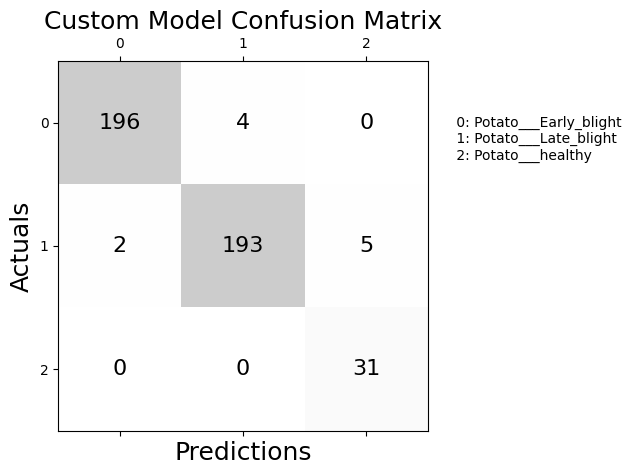

               early_blight   late_blight    healthy
--------------------------------------------------
Recall         0.98           0.96           1.00
Precision      0.99           0.98           0.86


In [39]:
fig, ax = plt.subplots()
ax.matshow(model1_conf_matrix, cmap = 'Greys', alpha = 0.2)
for i in range(model1_conf_matrix.shape[0]):
    for j in range(model1_conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=f'{model1_conf_matrix[i,j]}', va='center', ha='center', fontsize = '16')
ax.text(x=2.7, y=0.3, s=f' 0: {class_names[0]}\n 1: {class_names[1]} \n 2: {class_names[2]}')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Custom Model Confusion Matrix', fontsize=18)
plt.show()

print(f'{'':<15}{'early_blight':<15}{'late_blight':<15}{'healthy'}')
print('-'*50)
print(f'{'Recall':<15}{model1_Recall_early_blight:<15.2f}{model1_Recall_late_blight:<15.2f}{model1_Recall_healthy:.2f}')
print(f'{'Precision':<15}{model1_Precision_early_blight:<15.2f}{model1_Precision_late_blight:<15.2f}{model1_Precision_healthy:.2f}')

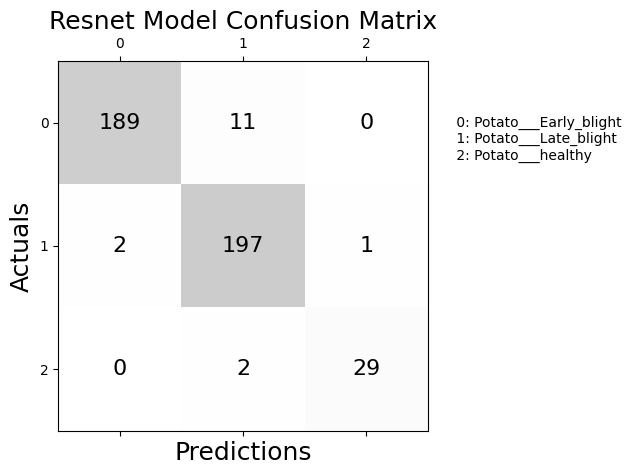

               early_blight   late_blight    healthy
--------------------------------------------------
Recall         0.94           0.98           0.94
Precision      0.99           0.94           0.97


In [40]:
fig, ax = plt.subplots()
ax.matshow(resnet_conf_matrix, cmap = 'Greys', alpha = 0.2)
for i in range(resnet_conf_matrix.shape[0]):
    for j in range(resnet_conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=f'{resnet_conf_matrix[i,j]}', va='center', ha='center', fontsize = '16')
ax.text(x=2.7, y=0.3, s=f' 0: {class_names[0]}\n 1: {class_names[1]} \n 2: {class_names[2]}')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Resnet Model Confusion Matrix', fontsize=18)
plt.show()

print(f'{'':<15}{'early_blight':<15}{'late_blight':<15}{'healthy'}')
print('-'*50)
print(f'{'Recall':<15}{resnet_Recall_early_blight:<15.2f}{resnet_Recall_late_blight:<15.2f}{resnet_Recall_healthy:.2f}')
print(f'{'Precision':<15}{resnet_Precision_early_blight:<15.2f}{resnet_Precision_late_blight:<15.2f}{resnet_Precision_healthy:.2f}')